- Adam Napora
- 18197892

In [7]:
# allows to see images in GitLab
from IPython.display import display, Image

## Intro

This is an implementation of Deep Q-Learning algorithm heavily inspired by this post: https://medium.com/analytics-vidhya/building-a-powerful-dqn-in-tensorflow-2-0-explanation-tutorial-d48ea8f3177a (shared by the peers in the Sulis Forum).

Here are the files and most important classes/functions used in this project (with a high level summary):
- **Task3-Train.ipynb** (this file) - used for glueing the pieces together and running the game training loop
- **Task3-Evaluate.ipynb** - used to visualize an Agent actually playing the game
- **rl_imports.py** - all the required functionality, which can be imported by the Training and Evaluation scripts. In the top section of this file we can find a bunch of configuration parameters (which I will explain later in this Notebook), then there are the main objects at high level described below:
    - **Agent** - *the most important* (and tricky) class in this project, where learning actually happens
    - **build_q_network** - function responsible for handling the architecture of Deep Neural Network
    - **GameWrapper** - class manages the frames received from the gym environment (preprocessing images etc.)
    - **ReplayBuffer** - this class is responsible for storing the Experiences for each step and generating random batches, which are used in training the evaluation Neural Network model

#### Quick comment on the implementation used:

If could start again I would have opted for a simplier implementation, but as I have already invested a few days in the training of this model, and the results achieved are quite good, it is too risky to try again with a new approach.

On the flip side the method utilised here covers a lot of advanced concepts, which I wasn't aware of before, so maybe it was worth the effort in the end?

## Hardware/Software used

Reinforcement learning is definitely a very hungry algorithm (it's actually starving all the time) and for complex problems, a good hardware is required to achieve sufficiently good results in a reasonable amount of time.

Training results below have been observed on my home-PC with:
- 11GB Nvidia GTX 1080ti
- 6 Core Intel i5
- 32GB or RAM
- Python 3.7 / Ubuntu 18.4

## Results achieved after 2 days+ of training

I have trained the models for over 2 days. I have used the parameters defined on top in the rl_import.py module. After over 2 days of training - Agent was able to receive a consistent Reward of 50 and when evaluated the model visually (using the Evaluate Notebook), I can see that the performance should match the human playing the game.

Below are the 3 screenshots to present the final performance:

- Game simulation (using the Evaluation Notebook), where Agent is capable of achieving a respecteble score of **63**:

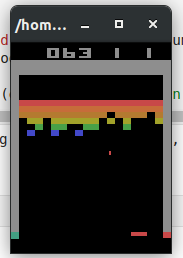

In [8]:
display(Image(filename='img/agent-playing.png'))

- Reward over time (taken from the final steps in TensorBoard):

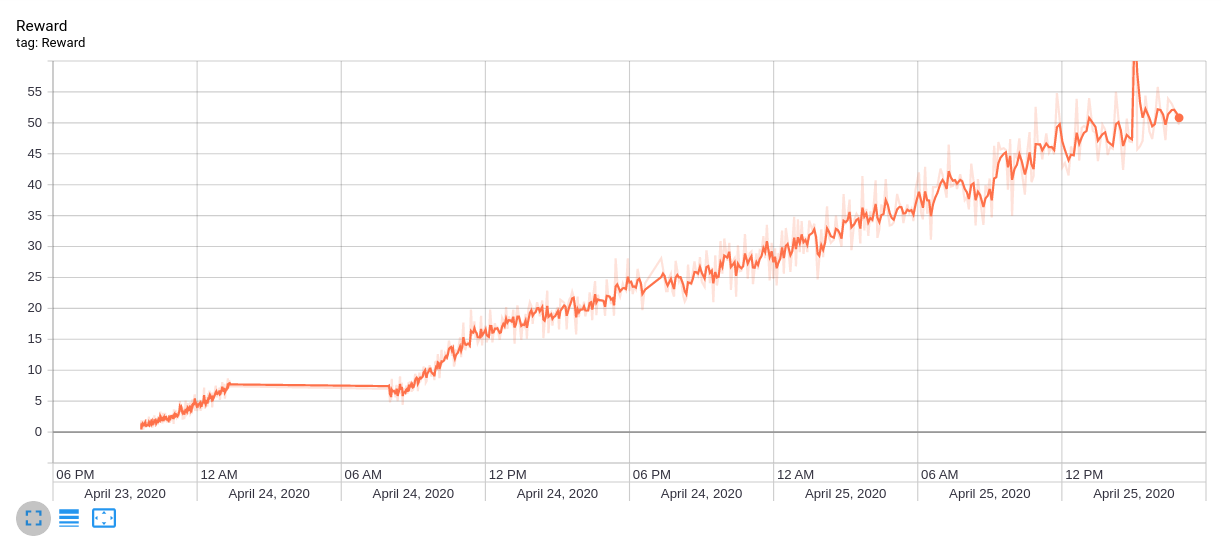

In [9]:
display(Image(filename='img/2days-reward.png', width=800))

- Loss over time from TensorBoard:

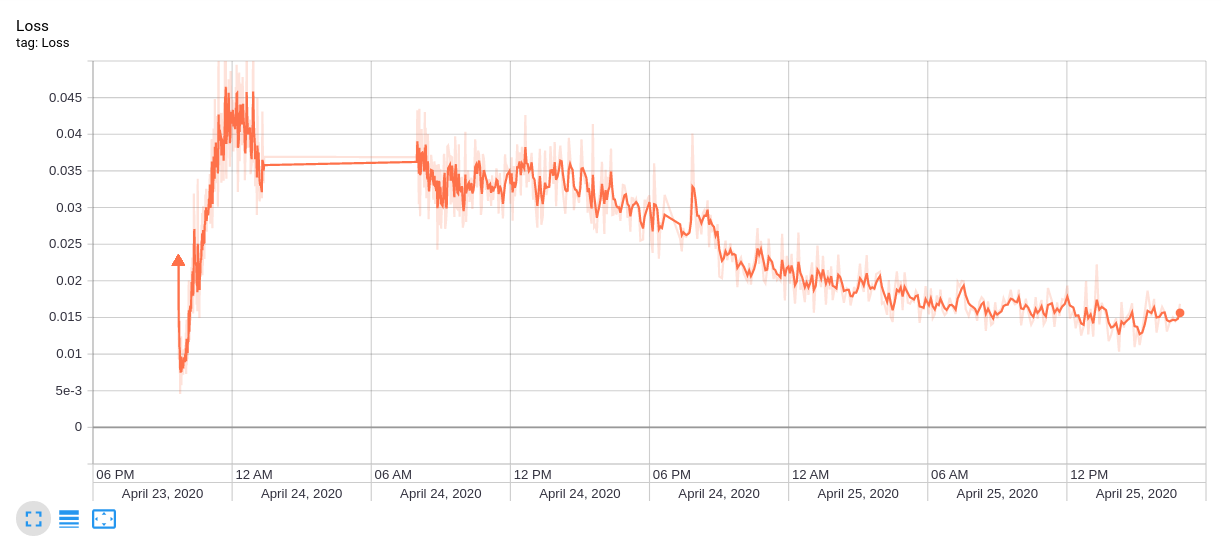

In [10]:
display(Image(filename='img/2days-loss.png', width=800))

Based on the plots above, we can conclude that there is still an area for improvement (if I could just let the model run for more time), as we did not get to the convergence yet.

## Other online resources/articles utilised:

The author of the blog post above has also mentioned following resources as his inspiration (which I have studied and used as well):
- https://www.youtube.com/watch?v=5fHngyN8Qhw
- https://towardsdatascience.com/tutorial-double-deep-q-learning-with-dueling-network-architectures-4c1b3fb7f756

I found an updated video by the same YouTuber as mentioned above, which was also very helpful (and the implementation was much more basic): https://www.youtube.com/watch?v=a5XbO5Qgy5w&feature=youtu.be

The other 2 online studies (one tutorial, but 2 parts) helped me to understand the methodology a bit deeper:
- https://becominghuman.ai/lets-build-an-atari-ai-part-1-dqn-df57e8ff3b26
- https://becominghuman.ai/beat-atari-with-deep-reinforcement-learning-part-2-dqn-improvements-d3563f665a2c

And a YouTube series about Reinforcement Learning from sentdex (part 5 and 6 specifically) clarified the source code of DQNs a lot: https://www.youtube.com/watch?v=t3fbETsIBCY&t=1s

Other than that I have also learned about the Huber Loss function from the wiki: https://en.wikipedia.org/wiki/Huber_loss and I have also finally learned about and used TensorBoard ML visualisation library coming from TensorFlow 

All the work coming from the people above, stands on the shoulders of the following paper published in 2015 in Nature: https://www.nature.com/articles/nature14236

## Detail description of individual components

In [11]:
# Import Generic Libraries first
import numpy as np
import time
import tensorflow as tf

### build_q_network function

Why do we actually use a Neural Network at all instead of maintaining a tabular Q-Table (Q-Learning or Sarsa)?

1. For a complex environment with millions (and maybe billions) of potential states, we would need a humongous Q-table with values (out of which most would be 0 initially, and maybe even also at the end)
2. The memory footprint would be so big that it's just not practical (petabytes?)
3. This is where we can introduce something, which is good at approximating functions without storing all the states in memory. And Neural Networks are the best choice for us. They can see a new state, which hasn't been seen before, and based on other similar ones, we can predict an action, which our Agent should take.

This in theory sounds simple and obvious, but there are many things, which we need to consider to use NN's in the Reinforcement Learning setting.

The ```build_q_network``` function builds a Convolutional Neural Network using Keras functional interface.

The input is the state of the environment (so in this case 84x84x4, 4 due to stacking 4 frames together) and the output are the Q-Values for each action: Q(s,a).

The network architecture, which is often used (and was also used in the original paper Mnih et al. 2015) for DQN tends to be quite simple: a few Conv layers stacked, followed by a fully connected layer representing the possible actions (linear output).

In the source code, which I have followed in this exercise, the authors have observed that the default architecture can be improved.

Let's import the module, so we can actually show it.

In [12]:
from rl_imports import build_q_network

# we can create a sample network to visualise it
sample_network = build_q_network(4)
sample_network.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 84, 84, 4)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 84, 84, 4)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 20, 20, 32)   8192        lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 9, 9, 64)     32768       conv2d[0][0]                     
______________________________________________________________________________________________

As we can see, we normalise the inputs in the first Lambda function (divide by 255) and then we have 4 standard Conv2D layers with the relu activation.

Next, there are a few concepts, which deviate from a simple/standard ConvNet, which should be highlighted:

- The first improvement over the default implementation from the 2015's paper is the **dueling architecture**.

The purpose of this is to speed up the training. As mentioned in another article on the topic (https://towardsdatascience.com/dueling-deep-q-networks-81ffab672751):

"By explicitly separating two estimators, the dueling architecture can learn which states are (or are not) valuable, without having to learn the effect of each action for each state."

- The next important aspect of the networks is that (as later will be shown as we discuss the Agent class) we will be actually creating 2 Networks:
    - first (main network) will be used to give us the Q-Values for the current state, this network will be also constantly trained on a batch of random states from the ReplayMemory
    - second, which will be used on each step to predict the future Q-Values, this network is not trained, but we will copy the weights from the first network to this one every $N$ iterations
    
This approach helps us to achieve a better stability in the training, otherwise we are asking the same network for the future Q-Values, but it's constantly trained, so we are chasing our own tail.

- The last, but not least improvement over the standard Sequential implementation is the choice of the loss function to minimise.

Due to the nature of the training (we constantly update the model), we can observe a problem with using the mean squared error loss:

$mse={(Target-Predicted)}^2$

The characteristics of this error function is that it penalises large errors, which is usually a good thing. However in the Reinforcement Learning setting this means that the Network will be radically adjusting to that behaviour and since the Network is trying to predict its own outputs, the targets will also change, and we won't be able to reduce the error very well.

As an alternative a Huber loss function has been proposed:

$
Huber(a)=
\begin{cases}
  \frac{1}{2}{a}^2, & \text{if } x\leq 1,\\
  |a|-\frac{1}{2},  & \text{otherwise.}
\end{cases}
$

This basically helps with clipping the high errors between -1 and 1 automatically, while keeping the good properties of a loss function (it differentiable at zero in comparison to the absolute error function). We can observe that the derivative does not increase when $a > 1$ and $a < -1$.

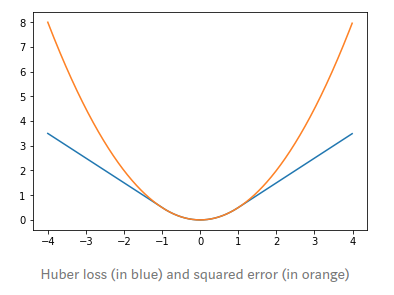

In [13]:
display(Image(filename='img/huber-loss.png', width=320))

The model is at the very end compiled with the standard Adam optimiser (with a very low default learning rate of 0.00001).

After all that we've ended up with a whooping 3,291,653 trainable parameters, which shows how complex Neural Networks can get. Let's keep in mind that we have already reduced the size of the original images by 14!

***

### GameWrapper class (and process_frame function)

This class is used to either reset the environment or take a step (instead of calling those directly on the environment, which was done in the previous Etivity).

It's important to understand that if we are using a ```*v4``` gym environment, the Agent will automatically skip a 4 frames (repeating the same action 4 times). This is done to reduce the load and replicate a more human-like reaction times.

Method roles and descriptions:
- ```__init__(args)```:
    - ```env``` is an instance variable containing the actual gym environment
    - ```state``` is ```None``` by default. It will keep track of the current state
    - ```last_lives``` is an info we receive from the gym environment, where we can keep track of the lives left, so we know when the Agent "lost its life"
    - ```history_length``` is a variable which will help us to understand the movement on the screen. We will stack $N$ number of frames, which will be fed into the Q-Network together
- ```reset(args)```:
    - here we are basically calling the gym's ```reset``` method and initially repeating the same initial state $N$ times
    - we also reset number of lives to 0
- ```step(args)```:
    - this method receives the standard ```(new_frame,reward,done,info)``` from the gym environment by taking a step (```action``` will be passed in to this method from outside)
    - we are actually using the ```info``` variable here as it contains the ```ale.lives``` property, which tells us how many lives left for the Agent to end and lose the game, here we are updating the ```self.last_lives``` instance variable to this value
    - next we are using the ```process_frame``` function defined earlier to:
        - convert the image to grayscale (AI does not need the color information in this instance)
        - crop redundant screen areas (like padding and score section)
        - resize to smaller size (moving from original 210x160x3 size to 84x84x1 will reduce a single observation size from 100,800 to 7,056), this is huge for the Neural Network operations and ReplayBuffer storage/performance
        - it's also important from the memory footprint point of view to set the data type to ```np.unit8``` (since we know that color scale is bound between 0 and 255)
        - the values are **not** normalised here, so we can keep them in the 0-255 range, otherwise they will become ```np.float32```, which takes much more memory and it's slower
    - then we append the frame to the current state (```self.state```) and remove the oldest frame
    - lastly we return ```(processed_frame,reward,terminal,life_lost)``` tuple like from the standard gym environment

In [14]:
from rl_imports import GameWrapper

***

### ReplayBuffer class

ReplayBuffer helps us to maintain a large enough number of "Experiences", which are saved in this list in a queue fashion.

In the training step, we sample a number of records (called minibatch) from this buffer randomly to break the chain of corresponding frames (we want the Network to learn how to behave in a variaty of situations).

The implementation here is however quite problematic from the performance point of view. Authors of this source code have utilised the ```deque``` module from the Standard Python library, which is quite slow in terms of the Random Access, and since the default number of records in the buffer is set to 1000,0000, it creates a bottleneck in the perfmance of the algorithm.

There is a proposal mentioned in the Part 1 of the tutorial mentioned above (https://becominghuman.ai/lets-build-an-atari-ai-part-1-dqn-df57e8ff3b26) to create a custom class with a Ring Buffer method and I would like to try it (or even try a standard numpy array list with the fixed size), but the time is my problem here.

The class below also has an interesting implementation of how can we prioritise certain states over another ones, where we sample the records with the higher priority, but it has been also mentioned that for the Breakout game this concept is an overkill and it significantly affects the performance.

So, in a nutshell we have 2 methods here, which will be utilised by the Agent: ```get_minibatch``` and ```add_experience```, which are self-explanatory.

In [15]:
from rl_imports import ReplayBuffer

***

### Agent class

```Agent``` is arguably the most important, and also the most complex class in our eco-system, so let's take a closer look at it.

As it's mentioned in the medium article with the original source, agent will:
- connect the replay buffer and the Q-network
- \[...\] hande \[...\] updating the target network
- perform gradient descent
- get actions

Here are the main functions, which require a little bit more explanation then given to us in the source code:
- ```calc_epsilon``` this internal method will return 1 (so always greedy approach/always exploit) if we are in the evaluation mode (i.e. testing the game while watching Agent playing), otherwise this is calculated dynamically to allow for the exploration, based on the frame number and if we have enough observations in the replay buffer. This method is actually quite tricky and I am planning to switch it to the standard epsilon-decay with the value of 0.99. The method used in the original source code relies on the study of OpenAI Baselines: DQL, which can be found here: https://openai.com/blog/openai-baselines-dqn/
- ```get_action``` here we will either explore the environment or follow the $\epsilon$-greedy approach and use the main DQN to **predict** the optimal action for the given state
- ```update_target_network``` this method only copies the weights from the main DQN to the Target DQN network
- ```add_experience``` only adds a single experience to the replay buffer
- ```learn``` is a little more complex, so let's break it down:
    - get a random minibatch from the replay buffer
    - use DQN to **predict** the best actions for the ```new_states``` in the minibatch
    - use TargetDQN to **predict** the future Q-Values for the ```new_states```
    - ```double_q``` with store the Q-Values for the optimal actions
    - then we are using the Bellman equation to calculate the targets: $r + \gamma * double_q * (1-done)$
    - then we use the targers to calculate errors and loss, and then loss to calculate the gradients
    - **Note:** I still don't understand why this is done manually, need more research here... My guess is that we want to keep track of the errors and the only way to do this is to calculate them manually
    - this function returns the loss and error as scalars
- ```save``` is used to save the models and objects on the drive
- ```load``` is used to load the models and objects from a snapshot

In [16]:
from rl_imports import Agent

***

### Configuration items

Here we can configure the main parameters used in the training.

My plan is to experiment with those in the next few days.

Unfortunately the training time is large and I was not able to run multiple models in parallel due to GPU memory issue.

The parameters to play with are:
- ```BATCH_SIZE``` - does changing the training batch size (defaul=64) change how to model performs? Does is increase the training speed?
- ```LEARNING_RATE``` - can we use a decaying learning rate?
- ```DISCOUNT_FACTOR``` - does changing the discount factor make any difference in training accuracy?
- ```USE_PER``` - how much heavier the algorithm is going to be on the machine when we switch on choosing higher priority states to train on in the replay buffer?
- ```MEM_SIZE``` - do we need to store the whole 1000,000 experiences in the replay buffer, what is the impact of decreasing that to 100,000 (10x)?

One intersting parameter, which is very helpful is ```LOAD_FROM```. We can use it to restart the training from a specified snapshot (instead of starting from scratch every time).

Another parameter here, which I have defined was the ```TENSORBOARD_DIR```. We will save the Losses and Rewards and we can push them to TensorBoard to observe the convergence in real time instead of rolling out our own matplotlib implementations. To see the TensorBoard dashboard, we need to navigate to the ```TENSORBOARD_DIR``` folder and execute a command:

```tensorboard --logdir="." --port 6006```

The dashboard will be available then at ```https://localhost:6006```

In [17]:
from rl_imports import (BATCH_SIZE, CLIP_REWARD, DISCOUNT_FACTOR, ENV_NAME,
                    EVAL_LENGTH, FRAMES_BETWEEN_EVAL, INPUT_SHAPE,
                    LEARNING_RATE, LOAD_FROM, MAX_EPISODE_LENGTH,
                    MAX_NOOP_STEPS, MEM_SIZE, MIN_REPLAY_BUFFER_SIZE,
                    SAVE_PATH, TOTAL_FRAMES, UPDATE_FREQ, WRITE_TENSORBOARD,
                    TENSORBOARD_DIR, USE_PER, LOAD_REPLAY_BUFFER, PRIORITY_SCALE)

### Update parameters from the defaults

The results (and plots) above were achieved by using the default parameters provided by the authors of the source code.

Due to the long training time, I did no get a chance to play with those a lot, and I have spent a lot of time on the research and understanding how it all works, especially that there are brand new ideas and concepts to grasp.

The parameters suggested by my below are currently being tested and so far provide promising results (Network seems to be training faster and much less memory is consumed after reducing the size of the Replay Buffer). I will describe briefly what they do and what is the achieved or expected behaviour of tweaking those.

In [18]:
# reduce the size of the replay buffer from 1M to 200K,
# this has actually sped up the training process, as the current Replay Buffer class
# uses Python deque method and it has issues with random access
MEM_SIZE = 200_000

In [19]:
# ** NEW PARAM: ** in the original implementation, author used UPDATE_FREQ (set to 4) to update 
# the weights in Target Network, this is obviously not enough even though it was also recommended 
# by the authors of the original. I am setting this to 1000 as it should help with the stability of
# the training, where the main Network is not chasing the tail of the Target Network
TARGET_UPDATE_FREQ = 1000

In [20]:
# make sure that we have this many experiences before we can actually start calculating gradients,
# changed from the original value of 50K
MIN_REPLAY_BUFFER_SIZE = 10_000

In [21]:
# just as an experiment, I have changed the learning rate from the default (very low) value of 0.000001,
LEARNING_RATE = 0.001

In [22]:
# unfortunately due to the way the epsilon is calculated (using the slope to decay as recommended
# by Fabio Graetz PHD in the excellent Notebook: https://github.com/fg91/Deep-Q-Learning/blob/master/DQN.ipynb),
# there is no ease way to play with the exploration rate decay, which was very successful when training the 
# tabular Q-Learning and Sarsa, I am happy with the initial value (1.0) and the final value (0.1), which means 
# that the Agent will initially explore the environment and then it will slowly degrade to the value of 0.1,
# which means that there is a 10% of a chance to explore, and 90% to use the Network to predict the future Q-Values
# Both of these parameters are set in the Agent's constructor:
# - eps_initial=1
# - eps_final=0.1
# Obviously in the evaluation script (the second Notebook in my submission) this needs to be
# set to 0 as we want the Agent to only exploit the learned Q-Values

In [23]:
# another parameter, which would be worth exploring is the size of a single batch to choose
# randomly from the ReplayBuffer and train the Neural Network,
# batch_size is also passed in to the Agent and the default value is 32,
# I am wondering if increasing the batch size to 64, 128 or even 256 would improve
# the training stability
# Unfortunately I did not get a chance to experiment with this parameter due to the lack of time and slow training

### Set up objects

This is where we initialise the script execution:
- we instantiate the ```GameWrapper``` and the ```TensorBoard``` writer
- we create 2 Neural Networks, which receive the data shape from the environment
- then we create an instance of the ```ReplayBuffer```, which will keep track of the experiences and we pass in all these objects to the brain - the ```agent``` object
- then we can either kick off a new training or pre-load it from the snapshot

In [24]:
# Create environment
game_wrapper = GameWrapper(ENV_NAME, MAX_NOOP_STEPS)
print(f"The environment has the following actions: {game_wrapper.env.unwrapped.get_action_meanings()}")

# TensorBoard writer
writer = tf.summary.create_file_writer(TENSORBOARD_DIR)

# Build main and target networks
MAIN_DQN = build_q_network(game_wrapper.env.action_space.n, LEARNING_RATE, input_shape=INPUT_SHAPE)
TARGET_DQN = build_q_network(game_wrapper.env.action_space.n, input_shape=INPUT_SHAPE)

replay_buffer = ReplayBuffer(size=MEM_SIZE, input_shape=INPUT_SHAPE, use_per=USE_PER)
agent = Agent(MAIN_DQN, TARGET_DQN, replay_buffer, game_wrapper.env.action_space.n, input_shape=INPUT_SHAPE, batch_size=BATCH_SIZE, use_per=USE_PER)

# Training and evaluation
if LOAD_FROM is None:
    print('New training (**not** loading from existing model)')
    frame_number = 0
    rewards = []
    loss_list = []
else:
    print('Loading from', LOAD_FROM)
    meta = agent.load(LOAD_FROM, LOAD_REPLAY_BUFFER)

    # Apply information loaded from meta
    frame_number = meta['frame_number']
    rewards = meta['rewards']
    loss_list = meta['loss_list']

    print('Loaded')

The environment has the following actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT']
New training (**not** loading from existing model)


### Run game loop and start training

This is the main logic applied to the frames received from the gym environment:
- The first, outer ```while``` loop just continues until we reach the end determined by ```TOTAL_FRAMES```, which is set to a very large number (so we don't need to worry that it will stop)
- In the second, inner ```while``` loop is running episodes. We reset the environment and set the ```episode_reward_sum``` to 0
- Then we create another ```for``` loop inside to run steps inside an episode:
    - get ```action``` for the current state (again, this will either choose a random action or **predict** an optimal action by running a pass through the DQN, depends on the $\epsilon$ value
    - next, we take a step using the environment and we get ```processed_frame,reward,terminal,life_lost```
    - this then becomes the Experience, which is added using our agent object and ```add_experience method```
    - then we check if we are ok to fit the DQN model (this only happens if we have enough experiences gathered in the replay buffer and if the ```UPDATE_FREQ``` is > 1, then we will execute this step only every ```UPDATE_FREQ``` frames)
    - from the ```learn``` step we receive the loss value, which we are keeping track of using TensorBoard
    - **IMPORTANT:** next step is to update the target network's weights. I think that the original source code has a bug here as it basically updates it every ```UPDATE_FREQ``` frames, but it should happen only every 10,000 frames or so. This might actually explain why the model took so long to train. My plan is to experiment with this code and set this to 10,000 and observe the results in the next few days
    - then, we verify if the game is over, and we break the loop if yes (we basically move on to the next episode)

The rest of the code only deals with TensorBoard and saving the snapshot of the models.

In [25]:
# Main loop
try:
    with writer.as_default():
        while frame_number < TOTAL_FRAMES:
            # Training

            epoch_frame = 0
            while epoch_frame < FRAMES_BETWEEN_EVAL:
                start_time = time.time()
                game_wrapper.reset()
                life_lost = True
                episode_reward_sum = 0
                for _ in range(MAX_EPISODE_LENGTH):
                    # Get action
                    action = agent.get_action(frame_number, game_wrapper.state)

                    # Take step
                    processed_frame, reward, terminal, life_lost = game_wrapper.step(action)
                    frame_number += 1
                    epoch_frame += 1
                    episode_reward_sum += reward

                    # Add experience to replay memory
                    agent.add_experience(action=action,
                                         frame=processed_frame[:, :, 0],
                                         reward=reward,
                                         clip_reward=CLIP_REWARD,
                                         terminal=life_lost)

                    # Update agent
                    if frame_number % UPDATE_FREQ == 0 and agent.replay_buffer.count > MIN_REPLAY_BUFFER_SIZE:
                        loss, _ = agent.learn(BATCH_SIZE, gamma=DISCOUNT_FACTOR, frame_number=frame_number, priority_scale=PRIORITY_SCALE)
                        loss_list.append(loss)

                    # Update target network
                    if frame_number % TARGET_UPDATE_FREQ == 0 and frame_number > MIN_REPLAY_BUFFER_SIZE:
                        agent.update_target_network()

                    # Break the loop when the game is over
                    if terminal:
                        terminal = False
                        break

                rewards.append(episode_reward_sum)

                # Output the progress every 10 games
                if len(rewards) % 10 == 0:
                    # Write to TensorBoard
                    if WRITE_TENSORBOARD:
                        tf.summary.scalar('Reward', np.mean(rewards[-10:]), frame_number)
                        tf.summary.scalar('Loss', np.mean(loss_list[-100:]), frame_number)
                        writer.flush()

                    print(f'Game number: {str(len(rewards)).zfill(6)}  Frame number: {str(frame_number).zfill(8)}  ' + 
                          f'Average reward: {np.mean(rewards[-10:]):.1f}  Time taken: {(time.time() - start_time):.1f}s')

            # Evaluation every `FRAMES_BETWEEN_EVAL` frames
            terminal = True
            eval_rewards = []
            evaluate_frame_number = 0

            for _ in range(EVAL_LENGTH):
                if terminal:
                    game_wrapper.reset(evaluation=True)
                    life_lost = True
                    episode_reward_sum = 0
                    terminal = False

                # Breakout requires a "fire" action (action #1) to start the
                # game each time a life is lost.
                # Otherwise, the agent would sit around doing nothing.
                action = 1 if life_lost else agent.get_action(frame_number, game_wrapper.state, evaluation=True)

                # Step action
                _, reward, terminal, life_lost = game_wrapper.step(action)
                evaluate_frame_number += 1
                episode_reward_sum += reward

                # On game-over
                if terminal:
                    eval_rewards.append(episode_reward_sum)

            if len(eval_rewards) > 0:
                final_score = np.mean(eval_rewards)
            else:
                # In case the game is longer than the number of frames allowed
                final_score = episode_reward_sum
            # Print score and write to tensorboard
            print('Evaluation score:', final_score)
            if WRITE_TENSORBOARD:
                tf.summary.scalar('Evaluation score', final_score, frame_number)
                writer.flush()

            # Save model
            if len(rewards) > 300 and SAVE_PATH is not None:
                agent.save(f'{SAVE_PATH}/save-{str(frame_number).zfill(8)}', frame_number=frame_number, rewards=rewards, loss_list=loss_list)
except KeyboardInterrupt:
    print('\nTraining exited early.')
    writer.close()

    if SAVE_PATH is None:
        try:
            SAVE_PATH = input('Would you like to save the trained model? If so, type in a save path, otherwise, interrupt with ctrl+c. ')
        except KeyboardInterrupt:
            print('\nExiting...')

    if SAVE_PATH is not None:
        print('Saving...')
        agent.save(f'{SAVE_PATH}/save-{str(frame_number).zfill(8)}', frame_number=frame_number, rewards=rewards, loss_list=loss_list)
        print('Saved.')

/home/adamsky/anaconda3/envs/yolov3-tf2-gpu/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/adamsky/anaconda3/envs/yolov3-tf2-gpu/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Game number: 000010  Frame number: 00001709  Average reward: 1.0  Time taken: 0.1s
Game number: 000020  Frame number: 00003446  Average reward: 1.1  Time taken: 0.1s
Game number: 000030  Frame number: 00005222  Average reward: 1.0  Time taken: 0.1s
Game number: 000040  Frame number: 00007182  Average reward: 1.6  Time taken: 0.2s
Game number: 000050  Frame number: 00008980  Average reward: 1.3  Time taken: 0.1s
Game number: 000060  Frame number: 00011167  Average reward: 2.2  Time taken: 2.3s
Game number: 000070  Frame number: 00012807  Average reward: 0.8  Time taken: 2.1s
Game number: 000080  Frame number: 00014418  Average reward: 0.7  Time taken: 1.4s
Game number: 000090  Frame number: 00016252  Average reward: 1.2  Time taken: 1.6s
Game number: 000100  Frame number: 00017926  Average reward: 0.8  Time taken: 2.3s
Game number: 000110  Frame number: 00019599  Average reward: 0.7  Time taken: 1.5s
Game number: 000120  Frame number: 00021231  Average reward: 0.7  Time taken: 2.3s
Game